# Plot of controllable HCHO fraction and estimated cancer cases

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

from cartopy_cmaqfile import cmaqfile

In [3]:
workdir = './'
data_dir = f'{workdir}/data'

## ocean mask file

In [4]:
ocnf = f'{data_dir}/oceanmask/12US1_surf.ncf'
ocn = xr.open_dataset(ocnf)
# 1 over land; NaN elsewhere; set threshold of 0.5 (i.e., mask if ocean > 0.5 grid cell area)
ocn_mask = xr.where(ocn['OPEN']>0.5, np.full(ocn['OPEN'].shape, np.nan), np.ones(ocn['OPEN'].shape)).squeeze().values
ocn.close()

## cmaq data

In [5]:
cases = [
    'CRACMM1',      # CRACMM1 base case
    'CRACMM2',      # CRACMM2
    'ZUSA_NOX_ROC', # zero out anthropogenic NOx and ROC emissions
]

indir = f'{data_dir}/cancer_risk'
hcho = {case: xr.open_dataset(f'./{indir}/hcho_risk_annual_2019_{case}.nc') for case in cases}

## ACS 2019 gridded population data

In [6]:
acs_fn = f'{indir}/acs_2019_5yr_bg_pop_housing_12US1.nc'
acs_gr = xr.open_dataset(acs_fn, drop_variables=['COL', 'ROW'])

## CMAQ grid projection info

In [7]:
gridcro_fn = f'{data_dir}/gridcro/GRIDCRO2D_20190101.nc4'
gridcro = xr.open_dataset(gridcro_fn)
gridcro = cmaqfile(gridcro)
Xcorners, Ycorners = gridcro.getXYcorners()
cmaqproj = gridcro.getCMAQproj()

## plot helper functions and settings

In [8]:
def txt_annot(Z, fmt='.1f'):
    txt = f'{Z.mean():{fmt}} ({Z.min():{fmt}}, {Z.max():{fmt}})'
    plt.annotate(txt, xy=(0, -.08), xycoords='axes fraction')

In [9]:
def axis_fix(ax):
    ax.coastlines(lw=.25)
    ax.add_feature(cfeature.STATES, lw=.25)
    ax.add_feature(cfeature.BORDERS, lw=.25)
    ax.set_facecolor('grey')

In [10]:
plt.rcParams.update({'font.size': 10})

## calculate cancer cases

In [11]:
cancer_cases = {k: (ds['HCHO_cancer_risk'] * acs_gr['pop2019'].squeeze()).sum().item() for k, ds in hcho.items()}
cancer_cases['controllable'] = cancer_cases['CRACMM2'] - cancer_cases['ZUSA_NOX_ROC']
cancer_cases_noZUSA = {k: v for k, v in cancer_cases.items() if k != 'ZUSA_NOX_ROC'}

## plot

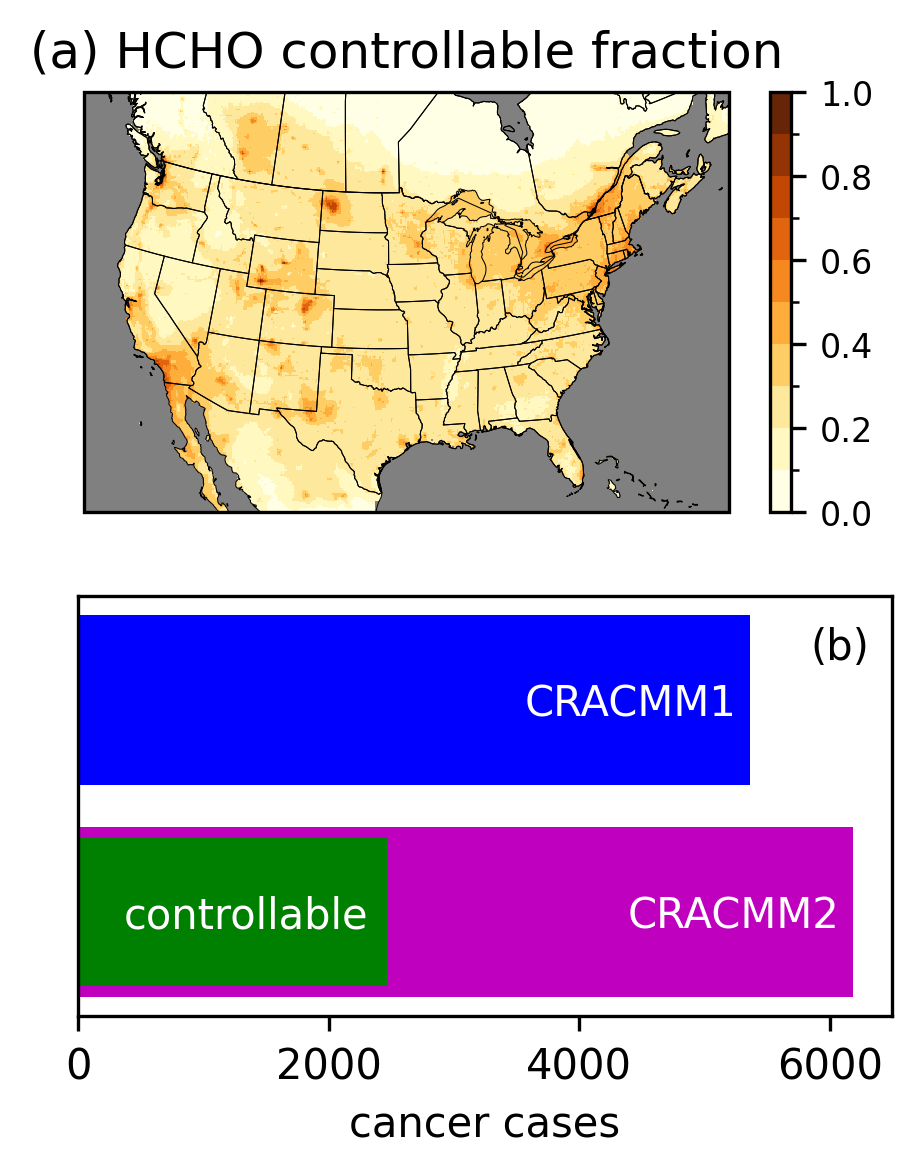

In [12]:
fig = plt.figure(figsize=(3.5, 4), dpi=300)

# spatial plot - controllable HCHO portion
bounds = np.arange(0., 1.01, .1)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')
ax1 = fig.add_subplot(211, projection=cmaqproj)
Z = ((hcho['CRACMM2']['HCHO'] - hcho['ZUSA_NOX_ROC']['HCHO'])/hcho['CRACMM2']['HCHO'])*ocn_mask
p = ax1.pcolormesh(
    Xcorners,
    Ycorners,
    Z,
    cmap='YlOrBr',
    norm=norm
)
cbar = plt.colorbar(p, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
# txt_annot(Z, fmt='.2f')
axis_fix(ax1)
ax1.set_title('(a) HCHO controllable fraction')

# bar chart of cancer cases
ax2 = fig.add_subplot(212)
# CRACMM1 and CRACMM2
cases = [cancer_cases_noZUSA['CRACMM1'], cancer_cases_noZUSA['CRACMM2']]
labels = ['CRACMM1', 'CRACMM2']
colors = ['b', 'm']
ax2.barh(
    [0, 1],
    cases,
    label=labels,
    color=colors
)
offsets = [1800, 1800]
for loc, val, key, offset in zip(range(2), cases, labels, offsets):
    ax2.annotate(key, (val-offset, loc+.075), xycoords='data', color='w')
plt.xlabel('cancer cases')
plt.yticks([])
ax2.invert_yaxis()
# CRACMM2 controllable
cases = [cancer_cases_noZUSA['controllable']]
labels = ['controllable']
colors = ['g']
ax2.barh(
    [1],
    cases,
    height=.7,
    label=labels,
    color=colors
)
offsets = [2100]
for loc, val, key, offset in zip([1], cases, labels, offsets):
    ax2.annotate(key, (val-offset, loc+.075), xycoords='data', color='w')
ax2.annotate('(b)', (.9, .85), xycoords='axes fraction', color='k')

fig.savefig('figures/fig07.tiff')